In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pygame

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import *
from IPython import display

import time
import copy

DEVICE = "cuda"

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Pathfinder stuff

In [2]:
#  0
#3   1
#  2

class Pathfinder(nn.Module):
    def __init__(self):
        pass
    
    def get_potential(self, costs, goal, cost_to_point = None, parent_cell = None, max_steps = 10):
        # costs: RES x RES
        # goal: (x,y)
        
        if cost_to_point is None:
            cost_to_point = torch.zeros(costs.shape[0], costs.shape[1]).to(DEVICE)+1e9
            parent_cell = torch.zeros(costs.shape[0], costs.shape[1]).long().to(DEVICE) - 1
        cost_to_point[goal[0], goal[1]] = 0
        
        changed = 1
        steps = 0
        while changed>0 and steps<max_steps:
            changed = 0
            steps += 1
            
            roll_xp = torch.cat([cost_to_point[1:,:], cost_to_point[:1,:]], 0) + costs
            roll_xm = torch.cat([cost_to_point[-1:,:], cost_to_point[:-1,:]], 0) + costs
            roll_yp = torch.cat([cost_to_point[:,1:], cost_to_point[:,:1]], 1) + costs
            roll_ym = torch.cat([cost_to_point[:,-1:], cost_to_point[:,:-1]], 1) + costs
            
            w = torch.lt(roll_xp+0.01, cost_to_point).float()
            cost_to_point = w*roll_xp + (1-w)*cost_to_point
            parent_cell = w*1 + (1-w)*parent_cell
            
            changed += torch.sum(w).detach().cpu().item()
            
            w = torch.lt(roll_xm+0.01, cost_to_point).float()
            cost_to_point = w*roll_xm + (1-w)*cost_to_point
            parent_cell = w*3 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()

            w = torch.lt(roll_yp+0.01, cost_to_point).float()
            cost_to_point = w*roll_yp + (1-w)*cost_to_point
            parent_cell = w*2 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()
            
            w = torch.lt(roll_ym+0.01, cost_to_point).float()
            cost_to_point = w*roll_ym + (1-w)*cost_to_point
            parent_cell = w*0 + (1-w)*parent_cell

            changed += torch.sum(w).detach().cpu().item()
        
        return cost_to_point, parent_cell
     
    def find_path(self, cost_to_point, parent_cell, start):
        path = []
        current = start
        
        while (parent_cell[current[0], current[1]]>=0):
            path.append(copy.deepcopy(current))
            
            direction = parent_cell[current[0], current[1]]
            if direction == 0:
                current[1] -= 1
            elif direction == 1:
                current[0] += 1
            elif direction == 2:
                current[1] += 1
            else:
                current[0] -= 1
            
            current[0] = (current[0] + cost_to_point.shape[0])%cost_to_point.shape[0]
            current[1] = (current[1] + cost_to_point.shape[1])%cost_to_point.shape[1]
        return path

# Model stuff

In [3]:
from PIL import Image

pathfinder = Pathfinder()



In [57]:
class PathfindingAutomaton(nn.Module):
    def __init__(self, N, RES):
        self.parts = torch.fmod(torch.abs(torch.randn(N, 2).to(DEVICE))*RES, RES)
        self.field = torch.rand(RES,RES).to(DEVICE)
        self.RES = RES
        
        self.old_cost = []
        self.old_parent = []
        
        self.offsets = torch.FloatTensor(np.array([[-1,-1], [0, -1], [1,-1],
                                                   [-1,0], [0,0], [1,0],
                                                   [-1,1], [0,1], [1,1]])).to(DEVICE)
        #self.offsets = torch.cat([self.offsets[:,1:], self.offsets[:,:1]], 1)
        
        for i in range(self.parts.shape[0]):
            goal = self.parts[i].cpu().detach().numpy().astype(np.int32)
            cost, parent = pathfinder.get_potential(self.field, goal, max_steps=256)
            self.old_cost.append(cost)
            self.old_parent.append(parent)
            
    def update(self, path_steps = 10, virtual_steps = 100):
        RES = self.RES
        idx = np.random.randint(self.parts.shape[0])
        goal = self.parts[idx].cpu().detach().numpy().astype(np.int32)
        cost_to_point, parent_cell = pathfinder.get_potential(torch.cos(self.field), goal, 
                                                              cost_to_point = self.old_cost[idx]+0.001, 
                                                              parent_cell = self.old_parent[idx],
                                                              max_steps = path_steps)
        self.old_cost[idx] = cost_to_point
        self.old_parent[idx] = parent_cell
        
        cost_to_point = -torch.mean(torch.cat([c.unsqueeze(0) for c in self.old_cost],0),0)
        
        # Heal towards 1
        #self.field = torch.relu(self.field + 0.002 * (1-self.field)*self.field + \
        #                        torch.randn_like(self.field)*0.0-0.01)+0.01
        
        # patches is 1 x 9 x RES*RES
        padfield = cost_to_point.view(1,1,self.RES,self.RES)
        padfield = torch.cat([padfield[:,:,-1:,:], padfield, padfield[:,:,:1,:]], 2)
        padfield = torch.cat([padfield[:,:,:,-1:], padfield, padfield[:,:,:,:1]], 3)
        patches = F.unfold(padfield, 3, padding=0)
        patches = patches.view(9, RES*RES)
        
        virtual_parts = self.parts.clone()
        
        self.field = self.field.view(RES*RES)
        
        for i in range(virtual_steps):
            idx = virtual_parts.long()
            idx = idx[:,0] + idx[:, 1]*RES
            idx = idx.unsqueeze(0).expand(9, virtual_parts.shape[0])
            
            local_grads = torch.gather(dim=1, index = idx, input=patches)
            self.field.scatter_(dim=0, index = idx[0], src=torch.ones(virtual_parts.shape[0]).to(DEVICE)*0.02, reduce='add')
            
            best_idx = torch.argmax(-local_grads, 0)
            virtual_parts = torch.fmod(0.5 + virtual_parts + self.offsets[best_idx] + RES, RES) - 0.5
        
        idx = self.parts.long()
        idx = idx[:,0] + idx[:, 1]*RES
        idx = idx.unsqueeze(0).expand(9, virtual_parts.shape[0])

        local_grads = torch.gather(dim=1, index = idx, input=patches)
        self.field.scatter_(dim=0, index = idx[0], src=torch.ones(virtual_parts.shape[0]).to(DEVICE)*0.95, reduce='multiply')

        best_idx = torch.argmax(local_grads, 0)
        self.parts = torch.fmod(0.5 + self.parts + self.offsets[best_idx] + torch.randn_like(self.parts)*0.5 + RES, RES) - 0.5
            
        self.field = self.field.view(RES,RES)
        
        """
        for i in range(self.parts.shape[0]):
            partpos = self.parts[i].cpu().detach().numpy().astype(np.int32)
            print(partpos)
            path = pathfinder.find_path(cost_to_point, parent_cell, partpos)
            
            for p in path: # Erode
                self.field[p[0],p[1]] *= 0.99
        
            best_potential = 0
            best_cell = [0,0]
            
            for dx in range(-1,2):
                for dy in range(-1,2):
                    potential = cost_to_point[(partpos[0]+dx+RES)%RES, (partpos[1]+dy+RES)%RES]
                    if potential>best_potential:
                        best_cell = [dx,dy]
                        best_potential = potential
            
            self.parts[i,0] += best_cell[0]
            self.parts[i,1] += best_cell[1]
        self.parts = torch.fmod(0.5 + self.parts + RES, RES)-0.5
        """
        
    def render_parts(self):
        partpos = self.parts.long()
        src = torch.ones_like(self.field.view(-1))
        im = torch.zeros_like(self.field.view(-1))
        
        for dy in range(-1,2):
            for dx in range(-1,2):
                idx = (partpos[:,0]+dx+self.RES)%self.RES + ((partpos[:,1]+dy+self.RES)%self.RES)*self.RES

                im.scatter_add_(index = idx, dim=0, src=src)
        im = im.view(self.RES, self.RES).cpu().detach().numpy()
        
        return im

# User interface

In [46]:
pygame.init()
MULT = 2
screen = pygame.display.set_mode((256*MULT, 256*MULT), 0, 24)

In [58]:
automaton = PathfindingAutomaton(50, 256)
im = 1 - (np.array(Image.open("ref_image.jpg"))/384.0 + 0.25)
im = im.transpose(1,0)

cost = torch.FloatTensor(im).contiguous().to(DEVICE)
automaton.field = cost

In [59]:
with torch.no_grad():
    while True:
        automaton.update(path_steps=50)

        for event in pygame.event.get():
            if event.type == pygame.MOUSEBUTTONUP:
                mx = event.pos[0]
                my = event.pos[1]

                # Do stuff

            if event.type == pygame.KEYUP:
                if event.key == 'r':
                    # Do stuff
                    automaton = PathfindingAutomaton(50, 256)

        parts = np.clip(automaton.render_parts(),0,1)
        afield = 0.5+0.5*torch.cos(automaton.field).cpu().detach().numpy()
        
        im = np.clip((1-parts)*afield*256,0,255).astype(np.uint8)[:,:,np.newaxis]

        im = im.repeat(3, axis=2)
        im[:,:,0] += (255*parts).astype(np.uint8)

        im = im.repeat(MULT, axis=0)
        im = im.repeat(MULT, axis=1)
        s_image = pygame.pixelcopy.make_surface(im)

        screen.blit(s_image, (0, 0))

        pygame.display.update()   
        time.sleep(0.005)

KeyboardInterrupt: 

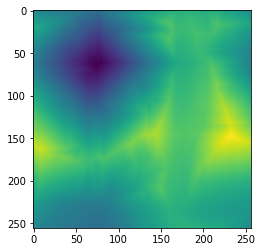

In [223]:
plt.imshow(automaton.old_cost[12].cpu().detach().numpy())

In [23]:
torch.min(automaton.field)

tensor(5.9266e-21, device='cuda:0')

In [117]:
parts.shape

(256, 256)